# Evaluate p-values on Atari100k test results for different algorithms
Author: r.casesa

The aim of this notebook is to compare different Reinforcement Learning algorithms against the Atari 100k benchmark and evaluate results from the paper "Deep Reinforcement Learning at the Edge of the Statistical Precipice".

The mentioned paper shows how evaluating algorithms based on a few sample's mean or median often leads to uncorrect results and proposes alternative metrics for algorithm evaluation.
We extend the treatment by including statistical tests. 

For each algorithm we plot results and test for normality. In fact t-test can be performed only on normally distributed data.
As the data appears to be non/normally distributed two approaches are tried out:
1. Transform the resulting data using a log transformation. This makes sense in general as data is skewed towards higher values of returns
2. Using tests which assume non normality.
3. Bootstrap data

## Question points
1. How do we handle non-normal data?
2. How do we handle the fact that the comparison should be performed on multiple tasks (games)
3. Which metric we can use?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import json
from scipy import stats
import itertools
import seaborn as sns


# ALE datapoints

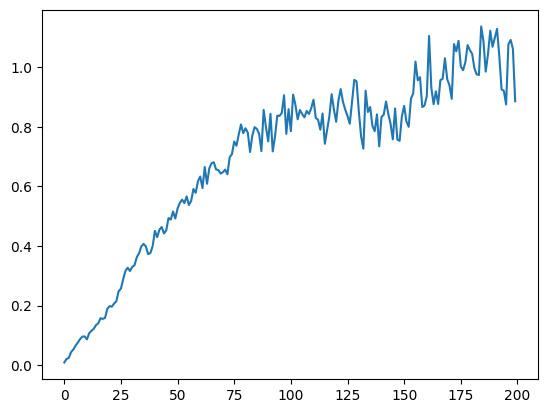

In [14]:
ale = np.load(r"ALE\atari_200_iters_normalized_scores.npy", allow_pickle=True)
ale = ale.tolist()
dqnN = ale['DQN (Nature)']
np.shape(dqnN)

plt.plot(dqnN[:,1,1])

Il risultato è che i data point per ALE sono in realtà relativi a un singolo training. Partono da zero e crescono.

# ATARI 100k
All'interno della cartella atari100k sono presenti 100 punti (simulazioni/game) per i seguenti algoritmi:
1. CURL
2. DER
3. OTrainbow
4. SPR
4. DrQ(eps)
4. DrQ

Per i seguenti algortmi invece:
1. SimPLe contiene 5 punti per game.
2. PlayVirtual contiene 14 punti per game.

In [2]:
with open(r'atari_100k\OTRainbow.json') as ff:
    a100 = json.load(ff)
rain_ret = a100

der_ret = dict()
for root, dirs, files in os.walk(r"atari_100k\DER"):
    for file in files:
        if file.endswith(".json"):
            with open(os.path.join(root, file)) as ff:
                a100 = json.load(ff)
                der_ret.update({file[:-5]: [i['eval_average_return'] for i in a100]})

curl_ret = dict()
for root, dirs, files in os.walk(r"atari_100k\CURL"):
    for file in files:
        if file.endswith(".json"):
            with open(os.path.join(root, file)) as ff:
                a100 = json.load(ff)
                curl_ret.update({file[:-5]: [i['eval_average_return'] for i in a100]})

with open(r'atari_100k\SPR.json') as ff:
    a100 = json.load(ff)
spr_ret = a100

with open(r'atari_100k\DrQ.json') as ff:
    a100 = json.load(ff)
drq_ret = a100

with open(r'atari_100k\DrQ(eps).json') as ff:
    a100 = json.load(ff)
drqeps_ret = a100

algo_bench = {'CURL': curl_ret, 'DER': der_ret, 'DrQ': drq_ret, 'DrQ(eps)': drqeps_ret, 'OTR': rain_ret, 'SPR': spr_ret}

In [7]:
games = list(rain_ret.keys())   # take a random algorithm from the list and extract the games. Assumes all algorithms have been tested against the same games.
M = len(games)
Nalgo = len(algo_bench.items())
algo_list = list(algo_bench.keys())

In [67]:

#@title Record scores on Atari games
record_scores = False

ALL_HUMAN_RECORD = {
  'Alien': 251916.0,
  'Amidar': 104159.0,
  'Assault': 8647.0,
  'Asterix': 1000000.0,
  'Asteroids': 10506650.0,
  'Atlantis': 10604840.0,
  'BankHeist': 82058.0,
  'BattleZone': 801000.0,
  'BeamRider': 999999.0,
  'Berzerk': 1057940.0,
  'Bowling': 300.0,
  'Boxing': 100.0,
  'Breakout': 864.0,
  'Centipede': 1301709.0,
  'ChopperCommand': 999999.0,
  'CrazyClimber': 219900.0,
  'DemonAttack': 1556345.0,
  'DoubleDunk': 22.0,
  'Enduro': 9500.0,
  'FishingDerby': 71.0,
  'Freeway': 38.0,
  'Frostbite': 454830.0,
  'Gopher': 355040.0,
  'Gravitar': 162850.0,
  'Hero': 1000000.0,
  'IceHockey': 36.0,
  'Jamesbond': 45550.0,
  'Kangaroo': 1424600.0,
  'Krull': 104100.0,
  'KungFuMaster': 1000000.0,
  'MontezumaRevenge': 1219200.0,
  'MsPacman': 290090.0,
  'NameThisGame': 25220.0,
  'Phoenix': 4014440.0,
  'Pitfall': 114000.0,
  'Pong': 21.0,
  'PrivateEye': 101800.0,
  'Qbert': 2400000.0,
  'Riverraid': 1000000.0,
  'RoadRunner': 2038100.0,
  'Robotank': 76.0,
  'Seaquest': 999999.0,
  'Skiing': -3272.0,
  'Solaris': 111420.0,
  'SpaceInvaders': 621535.0,
  'StarGunner': 77400.0,
  'Tennis': 21.0,
  'TimePilot': 65300.0,
  'Tutankham': 5384.0,
  'UpNDown': 82840.0,
  'Venture': 38900.0,
  'VideoPinball': 89218328.0,
  'WizardOfWor': 395300.0,
  'YarsRevenge': 15000105.0,
  'Zaxxon': 83700.0,
  'AirRaid': 23050.0,
  'Carnival': 2541440.0,
  'ElevatorAction': 156550.0,
  'JourneyEscape': -4317804.0,
  'Pooyan': 13025.0
}
RANDOM_SCORES = {
 'Alien': 227.8,
 'Amidar': 5.8,
 'Assault': 222.4,
 'Asterix': 210.0,
 'BankHeist': 14.2,
 'BattleZone': 2360.0,
 'Boxing': 0.1,
 'Breakout': 1.7,
 'ChopperCommand': 811.0,
 'CrazyClimber': 10780.5,
 'DemonAttack': 152.1,
 'Freeway': 0.0,
 'Frostbite': 65.2,
 'Gopher': 257.6,
 'Hero': 1027.0,
 'Jamesbond': 29.0,
 'Kangaroo': 52.0,
 'Krull': 1598.0,
 'KungFuMaster': 258.5,
 'MsPacman': 307.3,
 'Pong': -20.7,
 'PrivateEye': 24.9,
 'Qbert': 163.9,
 'RoadRunner': 11.5,
 'Seaquest': 68.4,
 'UpNDown': 533.4
}

HUMAN_SCORES = {
 'Alien': 7127.7,
 'Amidar': 1719.5,
 'Assault': 742.0,
 'Asterix': 8503.3,
 'BankHeist': 753.1,
 'BattleZone': 37187.5,
 'Boxing': 12.1,
 'Breakout': 30.5,
 'ChopperCommand': 7387.8,
 'CrazyClimber': 35829.4,
 'DemonAttack': 1971.0,
 'Freeway': 29.6,
 'Frostbite': 4334.7,
 'Gopher': 2412.5,
 'Hero': 30826.4,
 'Jamesbond': 302.8,
 'Kangaroo': 3035.0,
 'Krull': 2665.5,
 'KungFuMaster': 22736.3,
 'MsPacman': 6951.6,
 'Pong': 14.6,
 'PrivateEye': 69571.3,
 'Qbert': 13455.0,
 'RoadRunner': 7845.0,
 'Seaquest': 42054.7,
 'UpNDown': 11693.2
}

NORM_BASELINE = ALL_HUMAN_RECORD if record_scores else HUMAN_SCORES 


# Data distribution

NormaltestResult(statistic=486.4893446436832, pvalue=2.2918229192995385e-106)

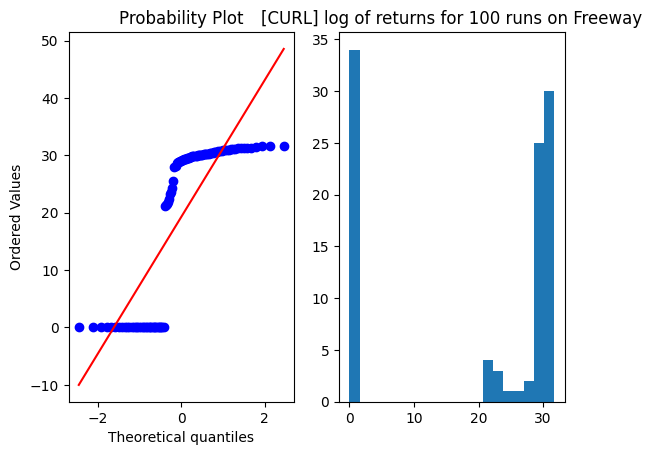

In [43]:
fig = plt.subplot(121)
stats.probplot(algo_bench['SPR']['Freeway'], plot=fig)
plt.subplot(122)
plt.hist(algo_bench['SPR']['Freeway'], bins=20)
plt.title('log of returns for 100 runs on Freeway')

stats.normaltest(algo_bench['SPR']['Freeway'])

In [8]:
# plt.hist(np.log(der_alien_ret), bins=20)
# fig = plt.subplot(121)
# stats.probplot(der_ret['Alien'], plot=fig)
# plt.subplot(122)
# plt.hist(der_ret['Alien'])
# plt.title('[DER] returns for 100 runs on Alien')

# stats.normaltest((der_ret['Alien']))

In [10]:
# plt.hist(np.log(der_alien_ret), bins=20)
# fig = plt.subplot(121)
# stats.probplot(np.log(rain_ret['Alien']), plot=fig)
# plt.subplot(122)
# plt.hist(np.log(rain_ret['Alien']))
# plt.title('[OTRainbow] returns for 100 runs on Alien')

# stats.normaltest(np.log(rain_ret['Alien']))

OK effettivamente sono presenti 100 punti. La distribuzione può essere quasi normalizzata

61 samples from a normal distribution out of 156


<AxesSubplot: >

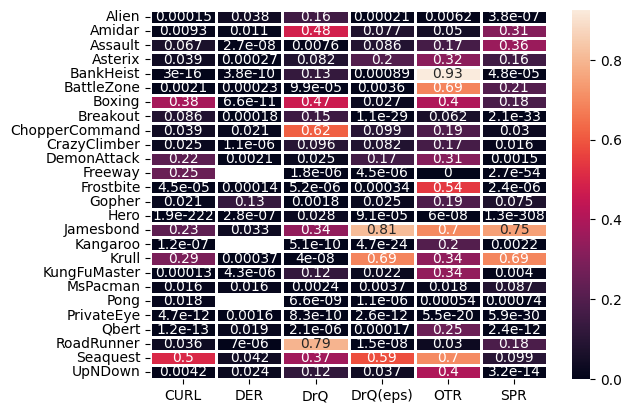

In [39]:

p_vals = np.zeros((M, len(algo_list)))
alpha = 0.05
trim = 0.05
smpl_len = 100
smpl_srt = int(smpl_len*trim/2)
smpl_end = smpl_len - smpl_srt

for alg_indx,  alg in zip(range(len(algo_list)), algo_list):
        for game_indx, game in zip(range(M), games):
                smpl = algo_bench[alg][game]
                smpl = np.sort(smpl)
                smpl = smpl[smpl_srt: smpl_end]
                _, p_vals[game_indx, alg_indx] = stats.normaltest(smpl)

fig, axs = plt.subplots(1,1)
# fig.set_figwidth(10)
# fig.set_figheight(10)
p_vals_mask = np.copy(p_vals)
p_vals_mask[p_vals <= alpha] = 0
p_vals_mask[p_vals > alpha] = 1
print(f"{np.sum(p_vals>alpha)} samples from a normal distribution out of {np.size(p_vals)}")
sns.heatmap(p_vals, linewidth=1, annot=True, xticklabels=algo_list, yticklabels=games, ax=axs)

104

# Multiple parameters test

Carica tutti i punti di simulazione.
Di seguito solamente caricati Rainbow, DER e CURL per iniziare.

Confronto tra Rainbow e DER

**WARNING** Il test deve valutare se la media è maggiore o minore. Non basta vedere che sono differenti. Per questo motivo selezioni come alternative hypothesis "less".

**WARNING** Yuen T Test è un test trimmed mean che é più robusto contro non-normalità. (TBC)

**WARNING** I diversi task non seguono spesso una distribuzione "normale"


Nel paper Stat Prec. viene usato l'IQM (inter quartile mean). E' analogo all'uso di trimming (Yuen test)?

In [86]:
games = list(rain_ret.keys())
p_vals_great = np.zeros(len(games))
p_vals_less = np.zeros(len(games))
p_vals_mood_great = np.zeros(len(games))
p_vals_mood_less = np.zeros(len(games))
K = 10    # Number or samples from the simulation
ttr = 0.1 # Trim value
alpha = 0.05
M = len(games)


for i, game in zip(range(len(games)), games):
        rain_smpl = random.sample(rain_ret[game], K)
        curl_smpl = random.sample(curl_ret[game], K)
        der_smpl = random.sample(der_ret[game], K)
        _, p_vals_great[i] = stats.ttest_ind(curl_smpl, der_smpl, equal_var=False, alternative='greater', trim=ttr)
        _, p_vals_less[i] = stats.ttest_ind(curl_smpl, der_smpl, equal_var=False, alternative='less', trim=ttr)
        _, p_vals_mood_great[i] = stats.mood(curl_smpl, der_smpl, alternative='greater')
        _, p_vals_mood_less[i] = stats.mood(curl_smpl, der_smpl, alternative='less')

In [83]:

idx_great = p_vals_great < alpha/2 # We divide by two applying the Bonferroni correction for multiple (two) tests.
idx_less = p_vals_less < alpha/2   # We divide by two applying the Bonferroni correction for multiple (two) tests.
idx_equal = (p_vals_great > alpha) & (p_vals_less > alpha)

if (idx_equal & idx_great | idx_equal & idx_less | idx_great & idx_less).any():
    raise ValueError



print(f'Mean test: Out of {len(games)} tests, {np.sum(idx_great)} accept the higher alternate hypothesis, {np.sum(idx_less)} accept the lesser alternate hypothesis and {np.sum(idx_equal)} accept the null hypothesis ')
print()

Mean test: Out of 26 tests, 4 accept the higher alternate hypothesis, 4 accept the lesser alternate hypothesis and 14 accept the null hypothesis 



In [87]:
alpha_crr = alpha/2


# Mean test
sorted_p_vals = np.sort(p_vals_great)
L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
idx = np.where(L_arr == True) 
fdr_idx_great = np.max(idx) + 1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

sorted_p_vals = np.sort(p_vals_less)
L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
idx = np.where(L_arr == True) 
fdr_idx_less = np.max(idx) +1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

score = (fdr_idx_less - fdr_idx_great)/M

print(f'Mean test:  Relative discoveries {score}')

Mean test:  Relative discoveries 0.0


E' proposta la metrica J = (fdr_idx_great - fdr_idx_less)/M.
NB questa metrica non tiene conto del valore assoluto di differenza tra i due algoritmi o di risultato tra i diversi game/task.

Si potrebbe anche usare una funzione f(J) che renda non lineare la risposta. Ovvero J piccolo (es. <0.3) non è molto indicativo. Meglio "forzarlo" a zero che è più intuitivo.

Plot della variazione per numero K diversi.

In [45]:
def relat_discov (alpha, p_vals_great, p_vals_less):
    alpha_crr = alpha/2
    sorted_p_vals = np.sort(p_vals_great)
    L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
    idx = np.where(L_arr == True)
    fdr_idx_great = np.max(idx) + 1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

    sorted_p_vals = np.sort(p_vals_less)
    L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
    idx = np.where(L_arr == True)
    fdr_idx_less = np.max(idx) +1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

    score = (fdr_idx_great - fdr_idx_less)/M
    return score

In [ ]:
def relat_improv (alpha, p_vals_great, p_vals_less, alg1_smpl_mean, alg2_smpl_mean):
    alpha_crr = alpha/2
    sorted_p_vals = np.sort(p_vals_great)
    L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
    idx = np.where(L_arr == True)
    p_vals_great_t = p_vals_great(np.where(p_vals_great==sorted_p_vals[idx]))
    fdr_idx_great = np.max(idx) + 1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

    sorted_p_vals = np.sort(p_vals_less)
    L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
    idx = np.where(L_arr == True)
    fdr_idx_less = np.max(idx) +1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

    score = (fdr_idx_great - fdr_idx_less)/M
    return score

In [73]:
def score_normalization(scores, min_scores, max_scores):
  # min should be random scores, max should be human scores.
  norm_scores = np.divide(scores - min_scores, max_scores - min_scores)
  return norm_scores

TypeError: unsupported operand type(s) for -: 'list' and 'float'

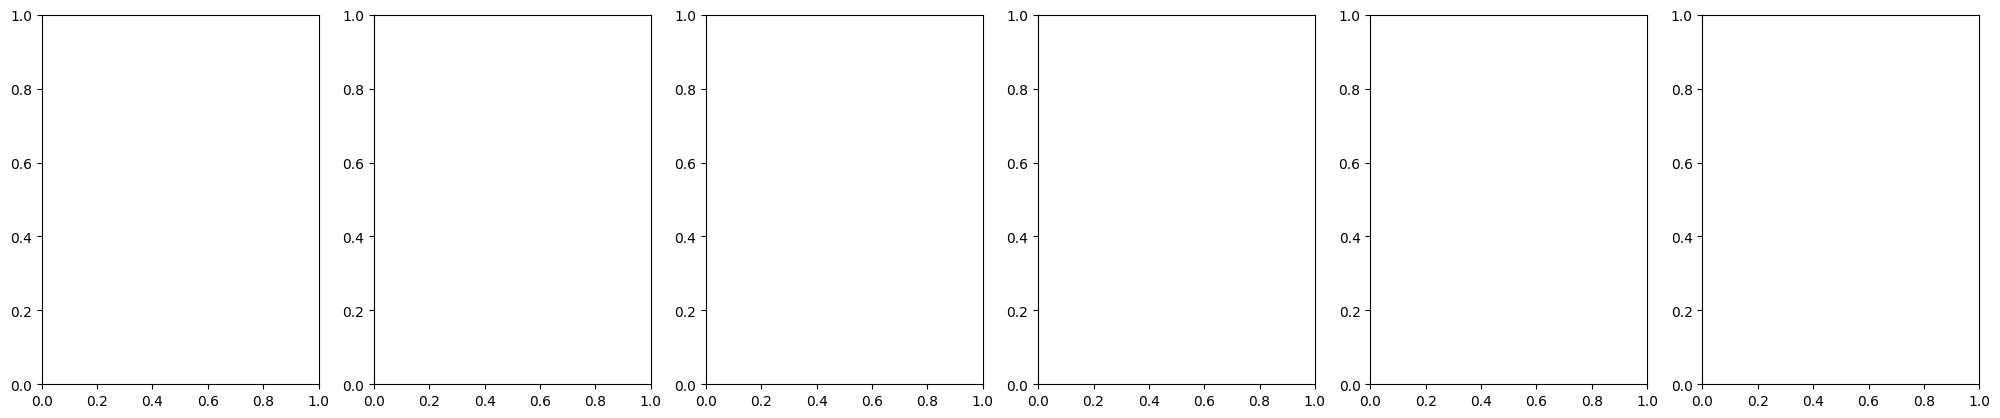

In [74]:
games = list(rain_ret.keys())
p_vals_great = np.zeros(len(games))
p_vals_less = np.zeros(len(games))
p_vals_mood_great = np.zeros(len(games))
p_vals_mood_less = np.zeros(len(games))
ttr = 0.1 # Trim value
alpha = 0.05
M = len(games)
Nalgo = len(algo_bench.items())
algo_list = list(algo_bench.keys())
Kv = np.array([3, 5, 10, 25, 50, 100])
K = 100    # Number or samples from the simulation
fig, ax = plt.subplots(1, len(Kv))
fig.set_figwidth(25)

for kk in range(len(Kv)):
        K = Kv[kk]
        J_matrix = np.zeros((Nalgo, Nalgo))
        M_matrix = np.zeros((Nalgo, Nalgo))
        for alg1, alg2 in itertools.combinations(algo_bench.keys(), 2):
                alg1_ret = algo_bench[alg1]
                alg2_ret = algo_bench[alg2]
                i1 = algo_list.index(alg1)
                i2 = algo_list.index(alg2)
                for i, game in zip(range(len(games)), games):
                        alg1_smpl = random.sample(alg1_ret[game], K)
                        alg2_smpl = random.sample(alg2_ret[game], K)
                        alg1_smpl = score_normalization(alg1_smpl, RANDOM_SCORES[game], HUMAN_SCORES[game])
                        alg2_smpl = score_normalization(alg2_smpl, RANDOM_SCORES[game], HUMAN_SCORES[game])
                        _, p_vals_great[i] = stats.ttest_ind(alg2_smpl, alg1_smpl, equal_var=False, alternative='greater', trim=ttr)
                        _, p_vals_less[i] = stats.ttest_ind(alg2_smpl, alg1_smpl, equal_var=False, alternative='less', trim=ttr)
                        # _, p_vals_mood_great[i] = stats.mood(curl_smpl, der_smpl, alternative='greater')
                        # _, p_vals_mood_less[i] = stats.mood(curl_smpl, der_smpl, alternative='less')

                J_score = relat_discov (alpha, p_vals_great, p_vals_less)
                J_matrix[i2, i1] = J_score

        mask = np.zeros_like(J_matrix)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(J_matrix, vmin=-1, vmax=1, linewidth=1, mask=mask, annot=True, xticklabels=algo_list, yticklabels=algo_list, ax=ax[kk])
        ax[kk].set_title(f"{K} samples")

c:\Users\r.casesa\OneDrive - Apogeo Space srl\Documenti\Codes\RL_pyenv\lib\site-packages\scipy\stats\_stats_py.py:6848: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  v = _calculate_winsorized_variance(a, g, axis)


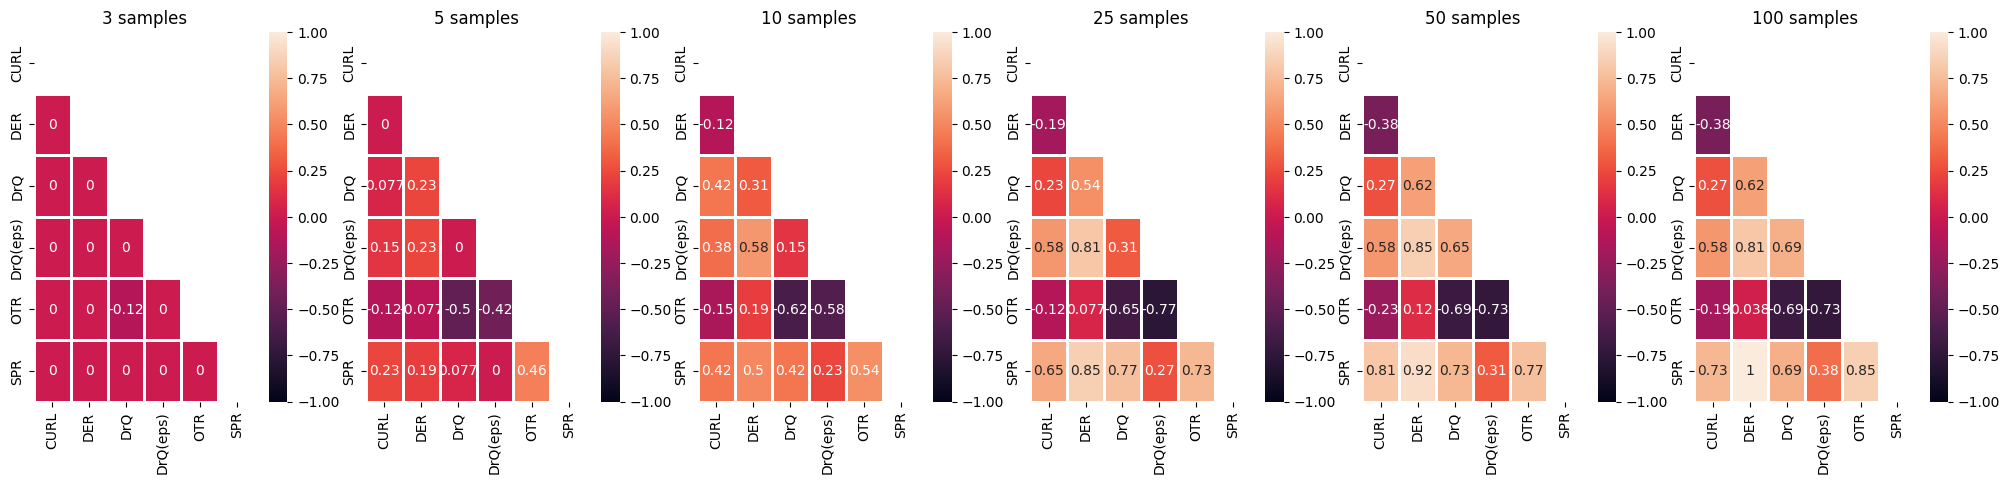

In [70]:
alg1_smpl_mean = np.zeros(len(games))
alg2_smpl_mean = np.zeros(len(games))
p_vals_great = np.zeros(len(games))
p_vals_less = np.zeros(len(games))
p_vals_mood_great = np.zeros(len(games))
p_vals_mood_less = np.zeros(len(games))
ttr = 0.1 # Trim value
alpha = 0.05
Kv = np.array([3, 5, 10, 25, 50, 100])
K = 100    # Number or samples from the simulation
fig, ax = plt.subplots(1, len(Kv))
fig.set_figwidth(25)

for kk in range(len(Kv)):
        K = Kv[kk]
        J_matrix = np.zeros((Nalgo, Nalgo))
        for alg1, alg2 in itertools.combinations(algo_bench.keys(), 2):
                alg1_ret = algo_bench[alg1]
                alg2_ret = algo_bench[alg2]
                i1 = algo_list.index(alg1)
                i2 = algo_list.index(alg2)
                for i, game in zip(range(len(games)), games):
                        alg1_smpl = random.sample(alg1_ret[game], K)
                        alg2_smpl = random.sample(alg2_ret[game], K)
                        
                        alg1_smpl_mean[i] = np.mean(alg1_smpl)
                        alg2_smpl_mean[i] = np.mean(alg2_smpl)
                        _, p_vals_great[i] = stats.ttest_ind(alg2_smpl, alg1_smpl, equal_var=False, alternative='greater', trim=ttr)
                        _, p_vals_less[i] = stats.ttest_ind(alg2_smpl, alg1_smpl, equal_var=False, alternative='less', trim=ttr)

                        J_score = relat_discov (alpha, p_vals_great, p_vals_less)
                        J_matrix[i2, i1] = J_score

        mask = np.zeros_like(J_matrix)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(J_matrix, vmin=-1, vmax=1, linewidth=1, mask=mask, annot=True, xticklabels=algo_list, yticklabels=algo_list, ax=ax[kk])
        ax[kk].set_title(f"{K} samples")

In [63]:
mean_a = np.zeros(M)
alpha_crr = alpha/2
sorted_p_vals = np.sort(p_vals_great)
L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
idx = np.where(L_arr == True)
p_vals_great_t = p_vals_great[np.where(p_vals_great==sorted_p_vals[np.max(idx)])]
idx_great = p_vals_great<= p_vals_great_t
mean_a[idx_great] = np.divide(alg2_smpl_mean - alg1_smpl_mean, alg1_smpl_mean)[idx_great]
# fdr_idx_great = np.max(idx) + 1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

# sorted_p_vals = np.sort(p_vals_less)
# L_arr = sorted_p_vals < alpha_crr*np.arange(M)/M
# idx = np.where(L_arr == True)
# fdr_idx_less = np.max(idx) +1 if np.size(idx) else 0 # 1 is added because otherwise the minimum idx would be 0 for the case of 1 significant test.

# score = (fdr_idx_great - fdr_idx_less)/M

In [66]:
alg2_smpl_mean

array([ 8.4189100e+02,  1.7971060e+02,  5.6561940e+02,  9.6248000e+02,
        3.4544100e+02,  1.4834100e+04,  3.5700000e+01,  1.9578800e+01,
        9.4630000e+02,  3.6700460e+04,  5.1762300e+02,  1.9275100e+01,
        1.1707460e+03,  6.6062000e+02,  5.8585520e+03,  3.6649000e+02,
        3.6173600e+03,  3.6816141e+03,  1.4783230e+04,  1.3183580e+03,
       -5.4119000e+00,  8.5992100e+01,  8.6628000e+02,  1.2213130e+04,
        5.5807800e+02,  1.0859179e+04])

11693.2